$$\large\textbf{Deep Learning para generación de moléculas}$$

$$\Large\textit{Jesus Alvarado-Huayhuaz}$$







_Cuaderno basado en "Deep Learning for the Life Sciences"_

# 1. Instalación

In [ ]:
!pip install --pre deepchem

In [ ]:
import deepchem as dc
dc.__version__

'2.6.1'

In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh 
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local 
! conda install -c rdkit rdkit -y 
import sys 
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
#import sys
#sys.path.append('/usr/local/lib/python3.6/site-packages/') 
import deepchem as dc
import numpy as np
import tensorflow as tf
import pandas as pd

# 2. Base de datos MUV

In [ ]:
tasks, datasets, transformers = dc.molnet.load_muv()
train_dataset, valid_dataset, test_dataset = datasets
train_smiles = train_dataset.ids

El conjunto de entrenamiento (*train*) consiste de 74469 moléculas de diferentes tamaños y estructuras. A continuación definiremos el vocabulario de nuestro modelo o la lista de caracteres "tokens" que pueden aparecer en un string. Así como también la longitud máxima de caracteres.

In [ ]:
tokens = set()

In [ ]:
for s in train_smiles:
  tokens = tokens.union(set(s))
tokens = sorted(list(tokens))
max_length = max(len(s) for s in train_smiles)

Construcción del modelo:

In [ ]:
from deepchem.models.optimizers import ExponentialDecay
from deepchem.models.seqtoseq import AspuruGuzikAutoEncoder
batch_size = 100
batches_per_epoch = len(train_smiles)/batch_size
learning_rate = ExponentialDecay(0.001, 0.95, batches_per_epoch)
model = AspuruGuzikAutoEncoder(tokens, max_length, model_dir='vae', batch_size=batch_size, learning_rate=learning_rate)

13:38 inicio del train_model, último click 14:46

In [ ]:
# Train the model.
def generate_sequences(epochs):
  for i in range(epochs):
    for s in train_smiles:
      yield (s, s)

model.fit_sequences(generate_sequences(1))

In [ ]:
import numpy as np
from rdkit import Chem
predictions = model.predict_from_embeddings(np.random.normal(size=(1000,196)))
molecules = []
for p in predictions:
  smiles = ''.join(p)
  if Chem.MolFromSmiles(smiles) is not None:
    molecules.append(smiles)
print()
print('Generated molecules:')
for m in molecules:
  print(m)


Generated molecules:


In [ ]:
smiles_list = ['CCCCCCNNNCCOCC','O=C(O)C(=O)ON/C=N/CO','C/C=N/COCCNSCNCCNN','CCCNC(C(=O)O)c1cc(OC(OC)[SH](=O)=O)ccc1N','CC1=C2C=CCC(=CC(Br)=CC=C1)C2','CCN=NNNC(C)OOCOOOOOCOOO','N#CNCCCCCOCCOC1COCNN1CCCCCCCCCCCCCCCCCCCOOOOOSNNCCCCCSCSCCCCCCCCCOCOOOSS','CCCC(=O)NC1=C(N)C=COO1','CCCSc1cc2nc(C)cnn2c1NC','CONCN1N=NN=CC=C1CC1SSS1','CCCOc1ccccc1OSNNOCCNCSNCCN','C[SH]1CCCN2CCN2C=C1N','CC1=C(C#N)N1NCCC1=COOO1','CN(NCNNNN)C(=O)CCSCc1ccco1','CCCN1CCC1CC=CC1=CC=S1CC=O','C/N=C/c1ccccc1','Nc1cccooo1','CCOc1ccccc1CCCNC(C)c1nccs1','CNNNNNNc1nocc1CCNNC(C)C','COC1=C(CON)C=C2C1=C(C)c1ccccc12','CCOCCCCNN(C)C','CCCN1C(=O)CNC1C','CCN','NCCNCc1cccc2c1C=CC=CC=C2','CCCCCN(NNNCNCCCCCCCCCCSCCCCCCCCCCCCCCNCCNCCCCSSCSSSSSSCCCCCCCCCCCCCSCCCCCSC)\C(O)OCCN','CCCS1=CC=C(C)N(CN)C2NCC2=C1','CCNCCCCCCOc1cccc(F)c1','NN1O[SH](CCCCO)C12C=C2','Cc1cc2cccc3c(CO)cc-3ccc-2c1']

In [ ]:
molecules = [Chem.MolFromSmiles(x) for x in smiles_list]

In [ ]:
print(sorted([x.GetNumAtoms() for x in molecules]))
#[3, 8, 9, 10, 11, 11, 12, 12, 13, 14, 14, 14, 15, 16, 16, 16, 17, 17, 17, 17, 18, 19, 19, 20, 20, 22, 24, 69, 80]

[3, 8, 9, 10, 11, 11, 12, 12, 13, 14, 14, 14, 15, 16, 16, 16, 17, 17, 17, 17, 18, 19, 19, 20, 20, 22, 24, 69, 80]


In [ ]:
good_mol_list = [x for x in molecules if x.GetNumAtoms() > 10
                 and x.GetNumAtoms() < 50]
print(len(good_mol_list))
#23

23


faltaba importar QED y qed

In [ ]:
import os
from rdkit.Chem import rdBase, RDConfig
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import qed
from rdkit.Chem import QED

In [ ]:
qed_list = [QED.qed(x) for x in good_mol_list]
final_mol_list = [(a,b) for a,b in zip(good_mol_list,qed_list) if b > 0.5]

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage

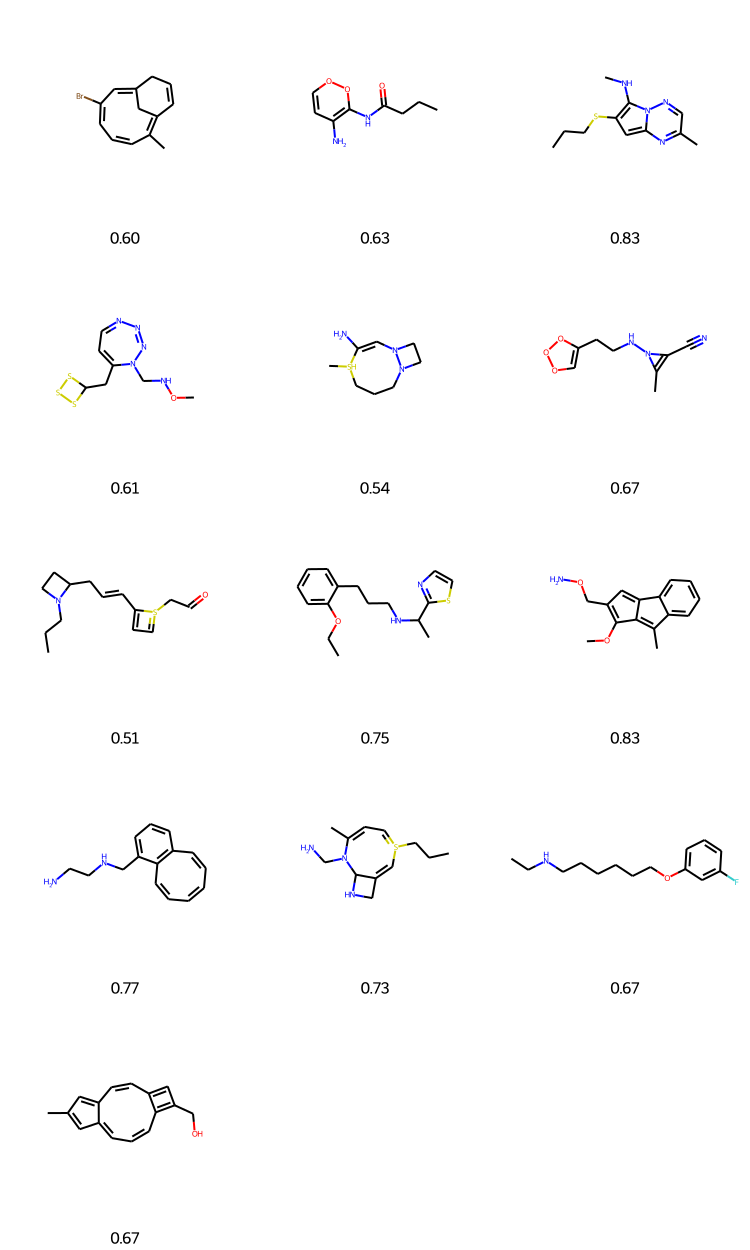

In [ ]:
MolsToGridImage([x[0] for x in final_mol_list],
molsPerRow=3,useSVG=True,
subImgSize=(250, 250),
legends=[f"{x[1]:.2f}" for x in final_mol_list])